In [1]:
# load some libraries
import sys
import os
import pickle
import gzip
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts import metrics

from lib.gluformer.model import *
from lib.latent_ode.trainer_glunet import *
from utils.darts_processing import *
from utils.darts_dataset import *

In [2]:
# plots of uninterpolated glucose data for each patient
# for plots showing splitting and interpolation, in winstock config file gap_threshold: 5, min_drop_length: 50
formatter, series, scalers = load_data(seed=0, study_file=None, dataset='weinstock', use_covs=True, use_static_covs=True)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Dropping columns / rows...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		Height: REAL_VALUED (STATIC_INPUT)
		Weight: REAL_VALUED (STATIC_INPUT)
		Gender: REAL_VALUED (STATIC_INPUT)
		Race: REAL_VALUED (STATIC_INPUT)
		EduLevel: REAL_VALUED (STATIC_INPUT)
		AnnualInc: REAL_VALUED (STATIC_INPUT)
		MaritalStatus: REAL_VALUED (STATIC_INPUT)
		DaysWkEx: REAL_VALUED (STATIC_INPUT)
		DaysWkDrinkAlc: REAL_VALUED (STATIC_INPUT)
		DaysMonBingeAlc: REAL_VALUED (STATIC_INPUT)
		T1DDiagAge: REAL_VALUED (STATIC_INPUT)
		NumHospDKA: REAL_VALUED (STATIC_INPUT)
		NumSHSinceT1DDiag: REAL_VALUED (STATIC_INPUT)
		InsDeliveryMethod: REAL_VALUED (STATIC_INPUT)
		UnitsInsTotal: REAL_VALUED (STATIC_INPUT)
		NumMeterCheckDay: REAL_VALUED (STATIC_INPUT)
		Aspir

In [3]:
# get ids from the data
ids = []
for i in range(len(series['train']['target'])):
    ids.append(series['train']['target'][i].static_covariates['id'][0])
# make a table of ids and how many of each id there are
ids_table = {id: 0 for id in ids}
for id in ids:
    ids_table[id] += 1
# select ids with most number of components
ids = [id for id in ids_table if ids_table[id] > 2]
# extract glucose data for each id
id_series = {id: [] for id in ids}
for i in range(len(series['train']['target'])):
    for id in ids:
        if np.isclose(series['train']['target'][i].static_covariates['id'][0], id):
            id_series[id].append(series['train']['target'][i])
# inverse scale glucose data
for id in ids:
    id_series[id] = scalers['target'].inverse_transform(id_series[id])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


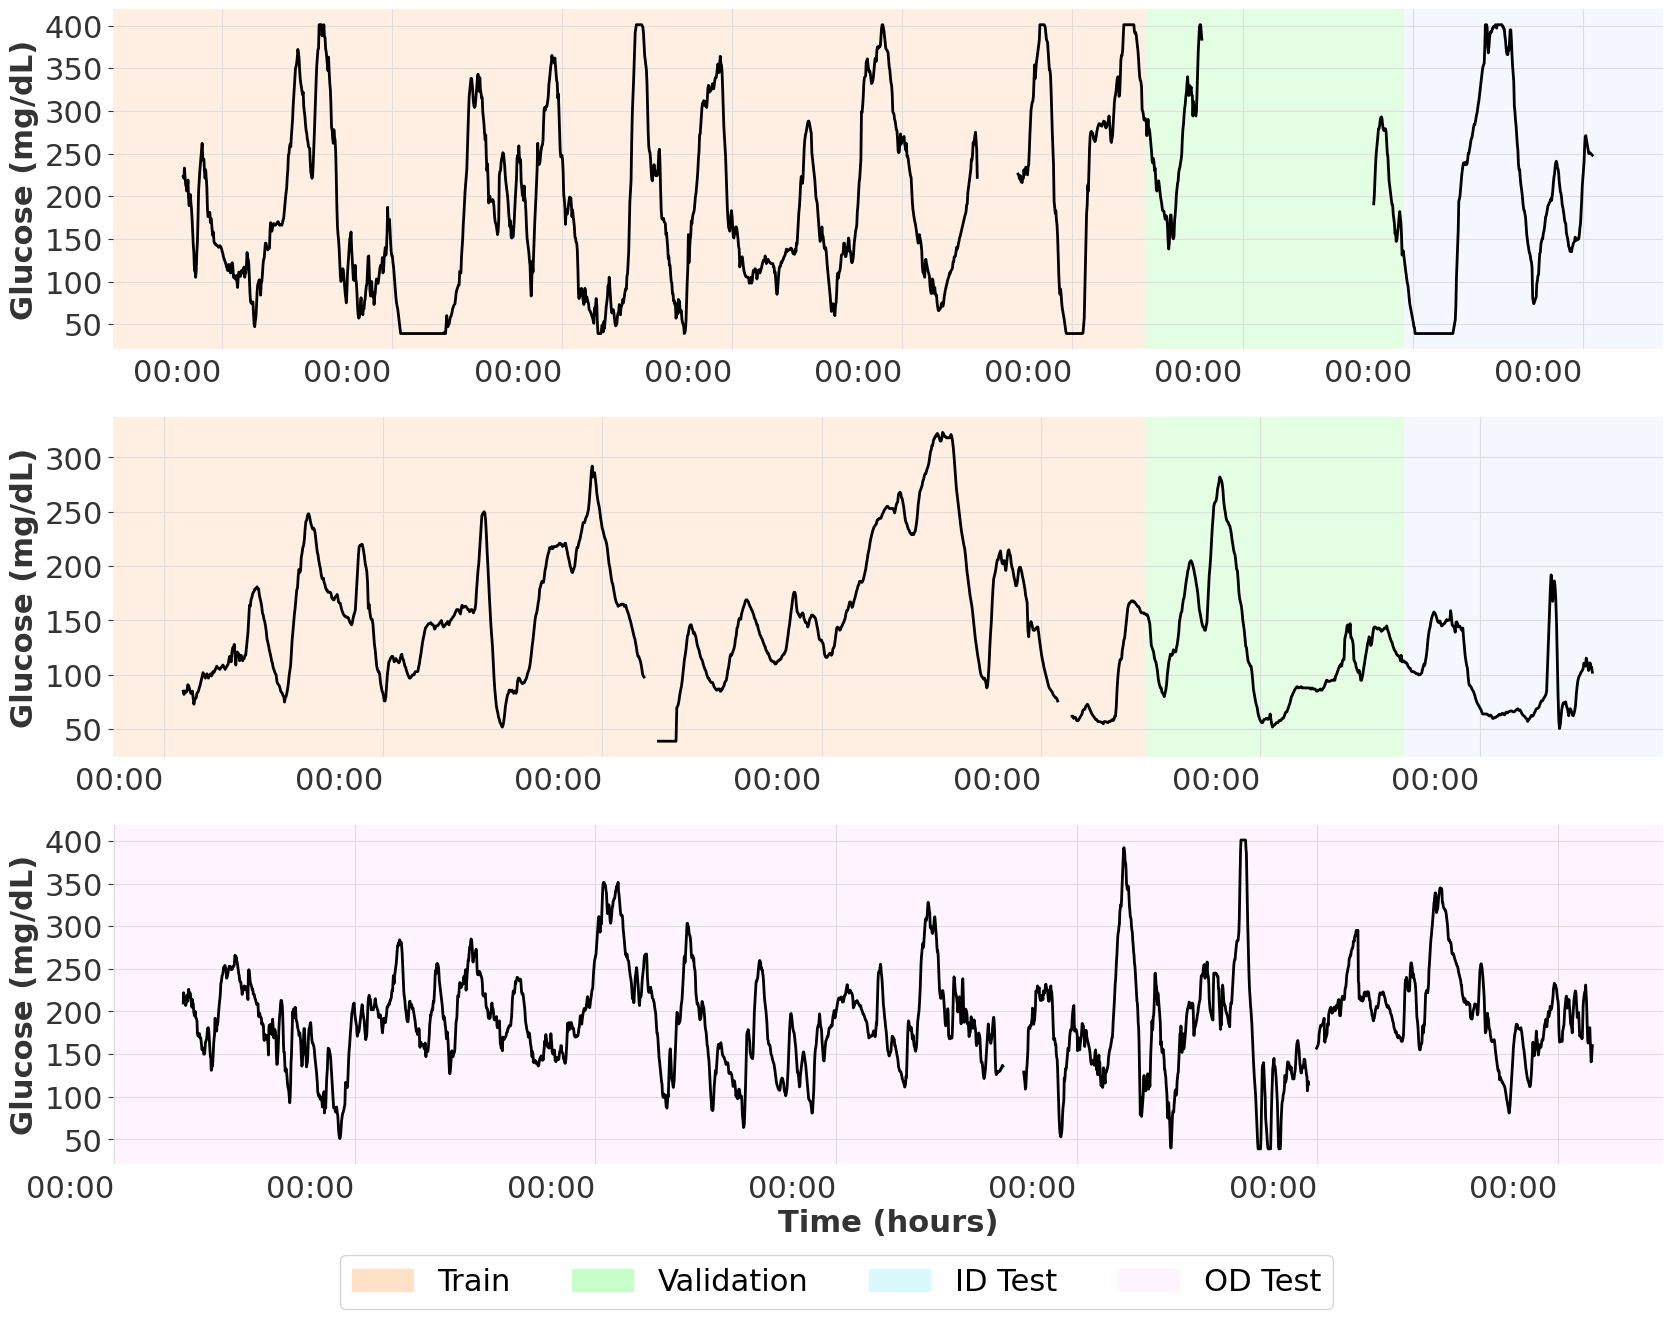

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# Define the colors for the rectangles
colors = ['#FEE1C7', '#C8FEC7', '#DAF9FE', '#FEF4FF']
labels = ['Train', 'Validation', 'ID Test', 'OD Test']

# plot glucose data for each id
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
for i, id in enumerate(ids[:3]):
    for j in range(len(id_series[id][:3])):
        # Set the line color to black and remove the label
        id_series[id][j].plot(ax=axs[i], color='black', label='')  

    axs[i].legend().set_visible(False)  # Remove the legend after plotting the data

    if i < len(ids[:3]) - 1:  # Only create rectangles for the first two plots
        y_min, y_max = axs[i].get_ylim()
        x_min, x_max = axs[i].get_xlim()
        total_width = x_max - x_min
        first_width = total_width * 2/3
        second_width = (total_width - first_width) / 2

        for k, color in enumerate(colors):
            if k == 0:
                width = first_width
            else:
                width = second_width
            rect = Rectangle((x_min + sum(width for width in [first_width, second_width][:k]), y_min),
                             width, y_max - y_min, facecolor=color, alpha=0.5)
            axs[i].add_patch(rect)
    else:  # Set the background color of the last plot to #D6EDFE
        axs[i].set_facecolor('#FEF4FF')
        axs[i].set_xlabel('Time (hours)')  # Add x axis label to the third plot

    axs[i].set_ylabel('Glucose (mg/dL)')
    axs[i].set_title('')
    axs[i].tick_params(axis='x', rotation=0)

    # Display hours and minutes on the x-axis
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # increase font size
    for item in ([axs[i].xaxis.label, axs[i].yaxis.label] +
                axs[i].get_xticklabels() + axs[i].get_yticklabels()):
        item.set_fontsize(22)
        if i == 2:
            axs[i].xaxis.label.set_visible(True)  # Add x axis label only to the third plot
        else:
            axs[i].xaxis.label.set_visible(False)  # Hide x axis label for the first two plots
            
# Create a custom legend for the colors
legend_elements = [Rectangle((0, 0), 1, 1, facecolor=color, edgecolor=color, label=label)
                   for color, label in zip(colors, labels)]
fig.legend(handles=legend_elements, loc='lower center', ncol=len(colors), fontsize=22, frameon=True)

# save as pdf with transparent background
plt.savefig('paper_results/plots/figure3.pdf', bbox_inches='tight', transparent=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


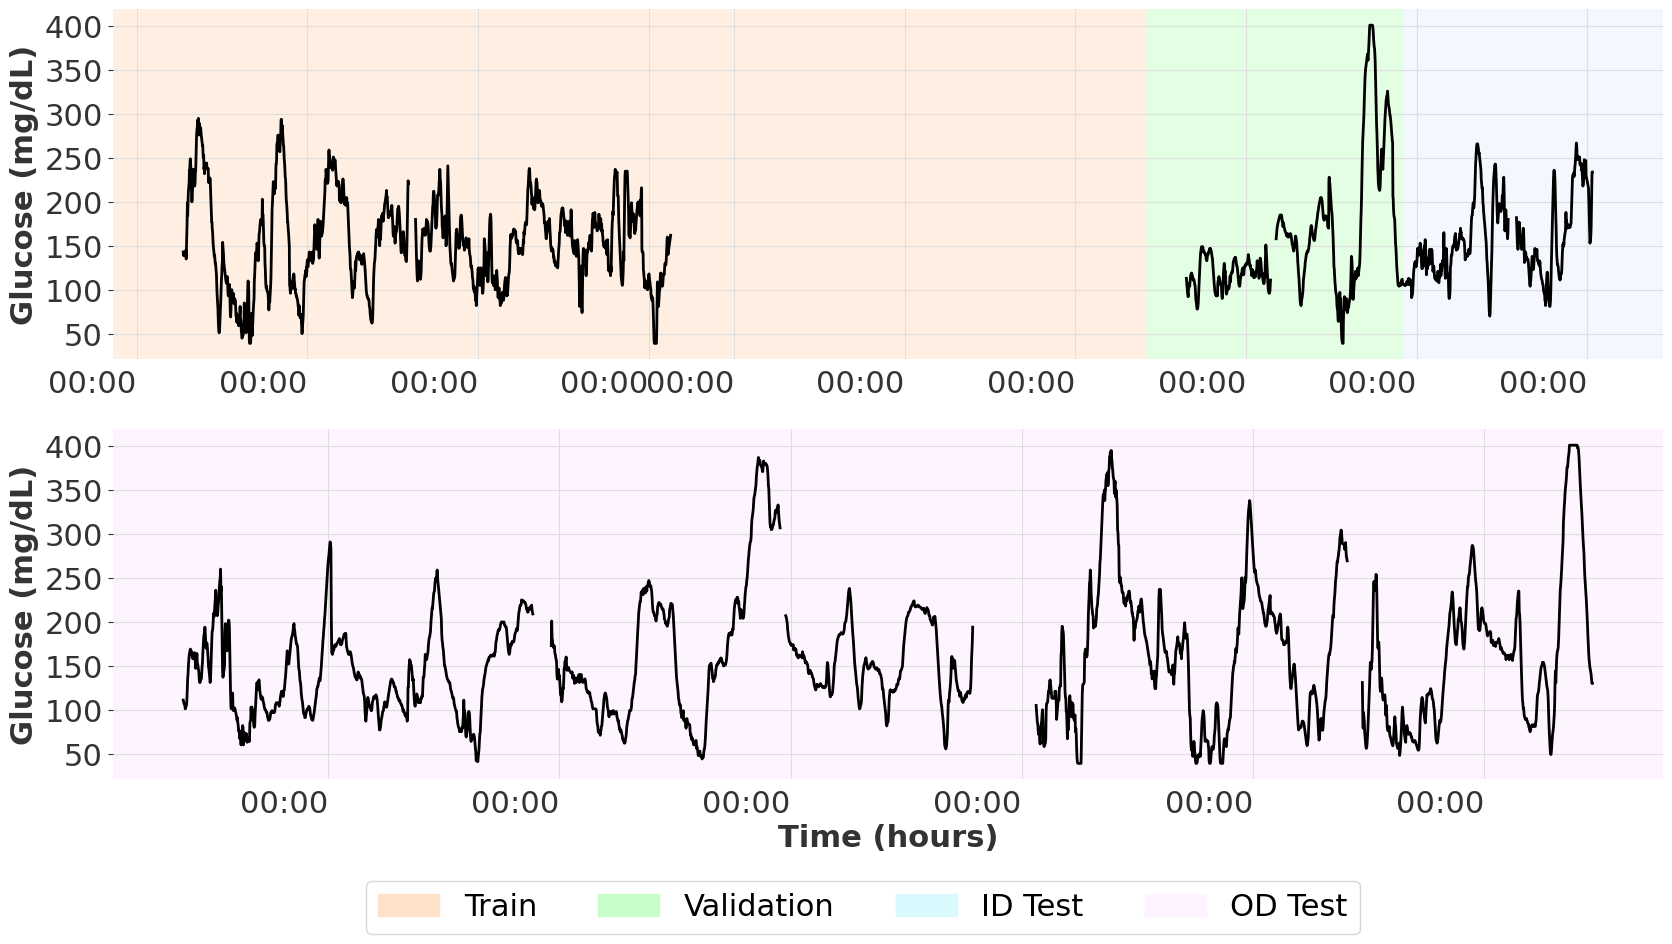

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# Define the colors for the rectangles
colors = ['#FEE1C7', '#C8FEC7', '#DAF9FE', '#FEF4FF']
labels = ['Train', 'Validation', 'ID Test', 'OD Test']

# plot glucose data for each id
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# Modify the loop to only iterate through the subjects you want
subject_indices = [26,14]  

for ax_idx, id_idx in enumerate(subject_indices):
    id = ids[id_idx]
    for j in range(len(id_series[id][:5])):
        # Set the line color to black and remove the label
        id_series[id][j].plot(ax=axs[ax_idx], color='black', label='') 

    axs[ax_idx].legend().set_visible(False)  # Remove the legend after plotting the data

    if ax_idx == 0:  # Only create rectangles for the first plot
        y_min, y_max = axs[ax_idx].get_ylim()
        x_min, x_max = axs[ax_idx].get_xlim()
        total_width = x_max - x_min
        first_width = total_width * 2/3
        second_width = (total_width - first_width) / 2

        for k, color in enumerate(colors):
            if k == 0:
                width = first_width
            else:
                width = second_width
            rect = Rectangle((x_min + sum(width for width in [first_width, second_width][:k]), y_min),
                             width, y_max - y_min, facecolor=color, alpha=0.5)
            axs[ax_idx].add_patch(rect)
    else:  # Set the background color of the last plot to #D6EDFE
        axs[ax_idx].set_facecolor('#FEF4FF')
        axs[ax_idx].set_xlabel('Time (hours)')  # Add x axis label to the third plot

    axs[ax_idx].set_ylabel('Glucose (mg/dL)')
    axs[ax_idx].set_title('')
    axs[ax_idx].tick_params(axis='x', rotation=0)

    # Display hours and minutes on the x-axis
    axs[ax_idx].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # increase font size
    for item in ([axs[ax_idx].xaxis.label, axs[ax_idx].yaxis.label] +
                axs[ax_idx].get_xticklabels() + axs[ax_idx].get_yticklabels()):
        item.set_fontsize(22)
        if ax_idx == 1:
            axs[ax_idx].xaxis.label.set_visible(True)  # Add x axis label only to the third plot
        else:
            axs[ax_idx].xaxis.label.set_visible(False)  # Hide x axis label for the first two plots
            
# Create a custom legend for the colors
legend_elements = [Rectangle((0, 0), 1, 1, facecolor=color, edgecolor=color, label=label)
                   for color, label in zip(colors, labels)]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.06), ncol=len(colors), fontsize=22, frameon=True)

# save as pdf with transparent background
plt.savefig('paper_results/plots/figure3.pdf', bbox_inches='tight', transparent=False)